<a href="https://colab.research.google.com/github/kandi00/Objectivity-detection/blob/main/Github_TextClassificationWithBERT_base_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import logging, AutoTokenizer, AutoModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class SubjDataset(Dataset):
    """Custom-built Subj dataset"""

    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y


    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [ ]:
def get_data_loaders(tokenizer):
  df_train = pd.read_csv('/content/drive/My Drive/Disszertacio/subj_train.tsv', sep = '\t')
  df_test = pd.read_csv('/content/drive/My Drive/Disszertacio/subj_test.tsv', sep = '\t')

  X_train = df_train['text']
  y_train = np.unique(df_train['label'], return_inverse=True)[1]
  X_test = df_test['text']
  y_test = np.unique(df_test['label'], return_inverse=True)[1]

  X_train_list = X_train.to_list()
  X = tokenizer(X_train_list, padding='max_length', max_length = 256, truncation=True, return_tensors='pt')["input_ids"]

  y_train_list = y_train.tolist()
  y = torch.Tensor(y_train_list).long()

  X_test_list = X_test.to_list()
  X_test = tokenizer(X_test_list, padding='max_length', max_length = 256, truncation=True, return_tensors='pt')["input_ids"]

  y_test_list = y_test.tolist()
  y_test = torch.Tensor(y_test_list).long()

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y_train)

  train_data_pt = SubjDataset(X=X_train, y=y_train)
  test_data_pt = SubjDataset(X=X_test, y=y_test)
  val_data_pt = SubjDataset(X=X_val, y=y_val)

  train_loader_pt = DataLoader(train_data_pt, batch_size=16)
  test_loader_pt = DataLoader(test_data_pt, batch_size=16)
  val_loader_pt = DataLoader(val_data_pt, batch_size=16)
  return train_loader_pt, test_loader_pt, val_loader_pt

In [ ]:
def calculate_metrics(valid_labels, predicted_labels):
    # Calculate accuracy
    accuracy = sum(1 for v, p in zip(valid_labels, predicted_labels) if v == p) / len(valid_labels)

    # Calculate true positives, false positives, and false negatives
    true_positives = sum(1 for v, p in zip(valid_labels, predicted_labels) if v == p and v == 1)
    false_positives = sum(1 for v, p in zip(valid_labels, predicted_labels) if v != p and p == 1)
    false_negatives = sum(1 for v, p in zip(valid_labels, predicted_labels) if v != p and v == 1)

    # Calculate precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    # Calculate recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score, true_positives, false_positives, false_negatives

In [ ]:
def train(train_loader_pt, test_loader_pt, val_loader_pt, bert_pt):

  num_classes = 2
  device = "cuda" if torch.cuda.is_available() else "cpu"
  class DistilBertClassification(nn.Module):
      def __init__(self):
          super(DistilBertClassification, self).__init__()
          self.dbert = bert_pt
          self.num_classes = 2
          self.dropout = nn.Dropout(p=0.5)
          self.linear = nn.Linear(bert_pt.config.hidden_size, num_classes)
          # BERT model is trainable
          for param in bert_pt.parameters():
            param.requires_grad_(True)

      def forward(self, x):
          x = self.dbert(input_ids=x)
          #  print(f"Size after BERT model: {x['last_hidden_state'].size()}")
          x = x["last_hidden_state"][:,0,:]
          #  print(f"Size after selecting the [CLS] token: {x.size()}")
          x = self.dropout(x)
          #  print(f"Size after dropout: {x.size()}")
          x = self.linear(x)
          #  print(f"Size after linear layer: {x.size()}")
          return x

  model_pt = DistilBertClassification().to(device)

  # print(model_pt)
  total_params = sum(p.numel() for p in model_pt.parameters())
  total_params_trainable = sum(p.numel() for p in model_pt.parameters() if p.requires_grad)
  print("Number of parameters: ", total_params)
  print("Number of trainable parameters: ", total_params_trainable)

  epochs = 5
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model_pt.parameters(), lr=1e-5, weight_decay=0.01)

  # Define the dictionary "history" that will collect key performance indicators during training
  history = {
      "epoch": [],
      "train_loss": [],
      "valid_loss": [],
      "train_accuracy": [],
      "valid_accuracy": [],
  }

  # Measure time for training
  start_time = datetime.now()

  # Move the model to GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model_pt.to(device)

  # Loop on epochs
  for e in range(epochs):

      # Set mode in train mode
      model_pt.train()

      train_loss = 0.0
      train_correct = 0
      train_total = 0

      # Loop on batches
      for X, y in tqdm(train_loader_pt):
          # Move data to GPU
          X, y = X.to(device), y.to(device)

          # Get prediction & loss
          prediction = model_pt(X)
          loss = criterion(prediction, y)

          # Adjust the parameters of the model
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()

          prediction_index = prediction.argmax(dim=1)
          train_correct += (prediction_index == y).sum().item()
          train_total += y.size(0)

      train_accuracy = train_correct / train_total

      # Calculate the loss on the validation data after each epoch
      model_pt.eval()
      valid_loss = 0.0
      valid_correct = 0
      valid_total = 0

      with torch.no_grad():
          for X, y in val_loader_pt:
              # Move data to GPU
              X, y = X.to(device), y.to(device)

              prediction = model_pt(X)
              loss = criterion(prediction, y)

              valid_loss += loss.item()

              prediction_index = prediction.argmax(dim=1)
              valid_correct += (prediction_index == y).sum().item()
              valid_total += y.size(0)

      valid_accuracy = valid_correct / valid_total

      # Populate history
      history["epoch"].append(e + 1)
      history["train_loss"].append(train_loss / len(train_loader_pt))
      history["valid_loss"].append(valid_loss / len(val_loader_pt))
      history["train_accuracy"].append(train_accuracy)
      history["valid_accuracy"].append(valid_accuracy)

      print(f'Epoch {e + 1} \t\t Training Loss: {train_loss / len(train_loader_pt) :10.3f} \t\t Validation Loss: {valid_loss / len(val_loader_pt) :10.3f}')
      print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')

  # Measure time for training
  end_time = datetime.now()
  training_time_pt = (end_time - start_time).total_seconds()

  # Testing the model after training and validation
  model_pt.eval()
  test_loss = 0.0
  test_accuracy = []

  all_labels = []
  all_predictions = []

  with torch.no_grad():
      for X, y in test_loader_pt:
          # Move data to GPU
          X, y = X.to(device), y.to(device)

          prediction = model_pt(X)
          loss = criterion(prediction, y)

          test_loss += loss.item()

          prediction_index = prediction.argmax(axis=1)
          accuracy = (prediction_index == y).float()
          test_accuracy.extend(accuracy.cpu().numpy())

          all_labels.extend(y.cpu().numpy())
          all_predictions.extend(prediction_index.cpu().numpy())

  # Calculate metrics
  accuracy, precision, recall, f1_score, true_positives, false_positives, false_negatives = calculate_metrics(all_labels, all_predictions)

  # Print results
  print(f'Test Loss: {test_loss / len(test_loader_pt) :10.3f}')
  print("Test Accuracy:", accuracy)
  print("Test Precision:", precision)
  print("Test Recall:", recall)
  print("Test F1 Score:", f1_score)
  print("Test false_positives:", false_positives)
  print("Test false_negatives:", false_negatives)

  return history

In [ ]:
def get_results(tokenizer, pretrained_model):
  train_loader_pt, test_loader_pt, val_loader_pt = get_data_loaders(tokenizer)
  return train(train_loader_pt, test_loader_pt, val_loader_pt, pretrained_model)

In [ ]:
def get_loss_figure(history):
  x_values = [1, 2, 3, 4, 5]

  fig, ax = plt.subplots(figsize=(6, 4))
  ax.set_facecolor('#f0f0f0')
  ax.set(title='Veszteség a tanítási és validálási adathalmazon')
  ax.plot(history['epoch'], history['train_loss'], label='Tanítási adathalmaz', color = 'red')
  ax.plot(history['epoch'], history['valid_loss'], label='Validációs adathalmaz')
  ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
  ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Veszteség')
  ax.legend(loc="upper right")

  plt.show()

In [ ]:
def get_accuracy_figure(history):
  x_values = [1, 2, 3, 4, 5]

  fig, ax = plt.subplots(figsize=(6, 4))
  ax.set_facecolor('#f0f0f0')
  ax.set(title='Pontosság a tanítási és validálási adathalmazon.')
  ax.plot(history['epoch'], history['train_accuracy'], label='Tanítási adathalmaz', color = 'red')
  ax.plot(history['epoch'], history['valid_accuracy'], label='Validációs adathalmaz')
  ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
  ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Pontosság')
  ax.legend(loc="lower right")

  plt.show()

  print(history)

  accuracy_pt = history['valid_accuracy'][-1]
  print('Accuracy Training data: {:.1%}'.format(history['train_accuracy'][-1]))
  print('Accuracy Validation data: {:.1%}'.format(history['valid_accuracy'][-1]))
  print('Accuracy Test data: {:.1%}'.format(history['test_accuracy'][-1]))
  print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_pt, training_time_pt/60))

In [ ]:
def main(config):
  history = []
  for config in config:
    tokenizer = AutoTokenizer.from_pretrained(config['tokenizer_name'])
    model = AutoModel.from_pretrained(config['model_name'])
    print(f"Testing model '{config['model_name']}' with tokenizer '{config['tokenizer_name']}'")

    result = get_results(tokenizer, model)

    get_loss_figure(result)

    history.append({
            'model_name': config['model_name'],
            'tokenizer_name': config['tokenizer_name'],
            'result': result
        })
    print(history)

Testing model 'bert-base-uncased' with tokenizer 'bert-base-uncased'
Number of parameters:  109483778
Number of trainable parameters:  109483778


100%|██████████| 450/450 [05:06<00:00,  1.47it/s]


Epoch 1 		 Training Loss:      0.362 		 Validation Loss:      0.143
		 Training Accuracy:    81.750% 		 Validation Accuracy:    95.375%


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 2 		 Training Loss:      0.109 		 Validation Loss:      0.136
		 Training Accuracy:    96.153% 		 Validation Accuracy:    94.750%


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 3 		 Training Loss:      0.060 		 Validation Loss:      0.104
		 Training Accuracy:    97.889% 		 Validation Accuracy:    96.625%


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 4 		 Training Loss:      0.033 		 Validation Loss:      0.091
		 Training Accuracy:    99.014% 		 Validation Accuracy:    97.375%


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 5 		 Training Loss:      0.018 		 Validation Loss:      0.125
		 Training Accuracy:    99.417% 		 Validation Accuracy:    96.250%
Test Loss:      0.185
Test Accuracy: 0.952
Test Precision: 0.9829059829059829
Test Recall: 0.92
Test F1 Score: 0.9504132231404959
Test false_positives: 16
Test false_negatives: 80


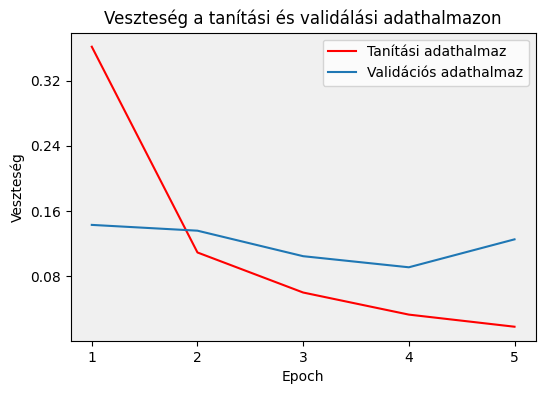

[{'model_name': 'bert-base-uncased', 'tokenizer_name': 'bert-base-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.3618444837857452, 0.10901771921431645, 0.059813148417872275, 0.03267154077578905, 0.017785118194458643], 'valid_loss': [0.14291205175220967, 0.13579777102917434, 0.10445050455629826, 0.09081972789717838, 0.12515681222314015], 'train_accuracy': [0.8175, 0.9615277777777778, 0.9788888888888889, 0.9901388888888889, 0.9941666666666666], 'valid_accuracy': [0.95375, 0.9475, 0.96625, 0.97375, 0.9625]}}]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Testing model 'bert-large-uncased' with tokenizer 'bert-large-uncased'
Number of parameters:  335143938
Number of trainable parameters:  335143938


100%|██████████| 450/450 [16:41<00:00,  2.23s/it]


Epoch 1 		 Training Loss:      0.475 		 Validation Loss:      0.108
		 Training Accuracy:    71.431% 		 Validation Accuracy:    96.375%


100%|██████████| 450/450 [16:41<00:00,  2.22s/it]


Epoch 2 		 Training Loss:      0.168 		 Validation Loss:      0.125
		 Training Accuracy:    93.708% 		 Validation Accuracy:    95.375%


100%|██████████| 450/450 [16:40<00:00,  2.22s/it]


Epoch 3 		 Training Loss:      0.101 		 Validation Loss:      0.122
		 Training Accuracy:    96.681% 		 Validation Accuracy:    95.500%


100%|██████████| 450/450 [16:39<00:00,  2.22s/it]


Epoch 4 		 Training Loss:      0.069 		 Validation Loss:      0.169
		 Training Accuracy:    97.861% 		 Validation Accuracy:    95.125%


100%|██████████| 450/450 [16:40<00:00,  2.22s/it]


Epoch 5 		 Training Loss:      0.042 		 Validation Loss:      0.079
		 Training Accuracy:    98.639% 		 Validation Accuracy:    97.750%
Test Loss:      0.136
Test Accuracy: 0.9685
Test Precision: 0.9579667644183774
Test Recall: 0.98
Test F1 Score: 0.9688581314878894
Test false_positives: 43
Test false_negatives: 20


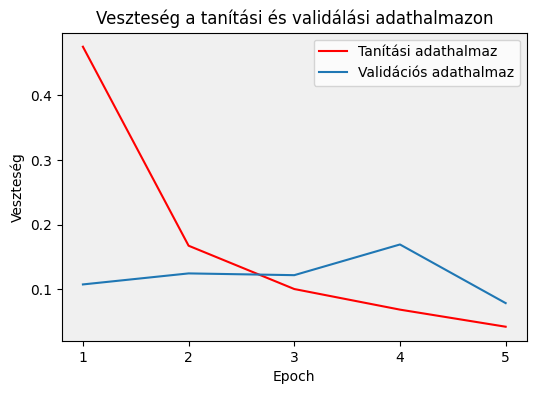

[{'model_name': 'bert-base-uncased', 'tokenizer_name': 'bert-base-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.3618444837857452, 0.10901771921431645, 0.059813148417872275, 0.03267154077578905, 0.017785118194458643], 'valid_loss': [0.14291205175220967, 0.13579777102917434, 0.10445050455629826, 0.09081972789717838, 0.12515681222314015], 'train_accuracy': [0.8175, 0.9615277777777778, 0.9788888888888889, 0.9901388888888889, 0.9941666666666666], 'valid_accuracy': [0.95375, 0.9475, 0.96625, 0.97375, 0.9625]}}, {'model_name': 'bert-large-uncased', 'tokenizer_name': 'bert-large-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.47493116392650536, 0.1675565809932434, 0.10065933298009137, 0.06883113098770587, 0.04243016161968828], 'valid_loss': [0.10775871896184981, 0.12478385265916586, 0.12206688501872122, 0.16946982083842158, 0.07890753752813907], 'train_accuracy': [0.7143055555555555, 0.9370833333333334, 0.9668055555555556, 0.9786111111111111, 0.986388888888888

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Testing model 'bert-base-cased' with tokenizer 'bert-base-cased'
Number of parameters:  108311810
Number of trainable parameters:  108311810


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 1 		 Training Loss:      0.224 		 Validation Loss:      0.096
		 Training Accuracy:    90.083% 		 Validation Accuracy:    97.250%


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 2 		 Training Loss:      0.067 		 Validation Loss:      0.152
		 Training Accuracy:    97.583% 		 Validation Accuracy:    95.000%


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 3 		 Training Loss:      0.036 		 Validation Loss:      0.178
		 Training Accuracy:    98.736% 		 Validation Accuracy:    94.750%


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 4 		 Training Loss:      0.017 		 Validation Loss:      0.113
		 Training Accuracy:    99.347% 		 Validation Accuracy:    97.125%


100%|██████████| 450/450 [05:05<00:00,  1.47it/s]


Epoch 5 		 Training Loss:      0.019 		 Validation Loss:      0.116
		 Training Accuracy:    99.319% 		 Validation Accuracy:    97.250%
Test Loss:      0.149
Test Accuracy: 0.961
Test Precision: 0.9619238476953907
Test Recall: 0.96
Test F1 Score: 0.9609609609609608
Test false_positives: 38
Test false_negatives: 40


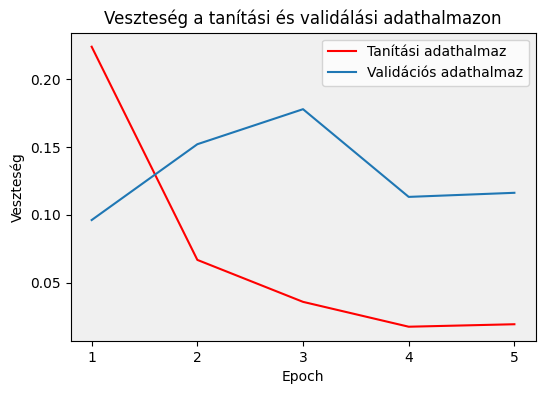

[{'model_name': 'bert-base-uncased', 'tokenizer_name': 'bert-base-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.3618444837857452, 0.10901771921431645, 0.059813148417872275, 0.03267154077578905, 0.017785118194458643], 'valid_loss': [0.14291205175220967, 0.13579777102917434, 0.10445050455629826, 0.09081972789717838, 0.12515681222314015], 'train_accuracy': [0.8175, 0.9615277777777778, 0.9788888888888889, 0.9901388888888889, 0.9941666666666666], 'valid_accuracy': [0.95375, 0.9475, 0.96625, 0.97375, 0.9625]}}, {'model_name': 'bert-large-uncased', 'tokenizer_name': 'bert-large-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.47493116392650536, 0.1675565809932434, 0.10065933298009137, 0.06883113098770587, 0.04243016161968828], 'valid_loss': [0.10775871896184981, 0.12478385265916586, 0.12206688501872122, 0.16946982083842158, 0.07890753752813907], 'train_accuracy': [0.7143055555555555, 0.9370833333333334, 0.9668055555555556, 0.9786111111111111, 0.986388888888888

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Testing model 'bert-large-cased' with tokenizer 'bert-large-cased'
Number of parameters:  333581314
Number of trainable parameters:  333581314


100%|██████████| 450/450 [16:40<00:00,  2.22s/it]


Epoch 1 		 Training Loss:      0.212 		 Validation Loss:      0.070
		 Training Accuracy:    90.431% 		 Validation Accuracy:    97.500%


100%|██████████| 450/450 [16:39<00:00,  2.22s/it]


Epoch 2 		 Training Loss:      0.052 		 Validation Loss:      0.112
		 Training Accuracy:    98.264% 		 Validation Accuracy:    96.250%


100%|██████████| 450/450 [16:39<00:00,  2.22s/it]


Epoch 3 		 Training Loss:      0.031 		 Validation Loss:      0.113
		 Training Accuracy:    99.042% 		 Validation Accuracy:    96.250%


100%|██████████| 450/450 [16:40<00:00,  2.22s/it]


Epoch 4 		 Training Loss:      0.019 		 Validation Loss:      0.106
		 Training Accuracy:    99.306% 		 Validation Accuracy:    96.375%


100%|██████████| 450/450 [16:40<00:00,  2.22s/it]


Epoch 5 		 Training Loss:      0.006 		 Validation Loss:      0.123
		 Training Accuracy:    99.819% 		 Validation Accuracy:    97.375%
Test Loss:      0.159
Test Accuracy: 0.9655
Test Precision: 0.9506292352371732
Test Recall: 0.982
Test F1 Score: 0.9660600098376783
Test false_positives: 51
Test false_negatives: 18


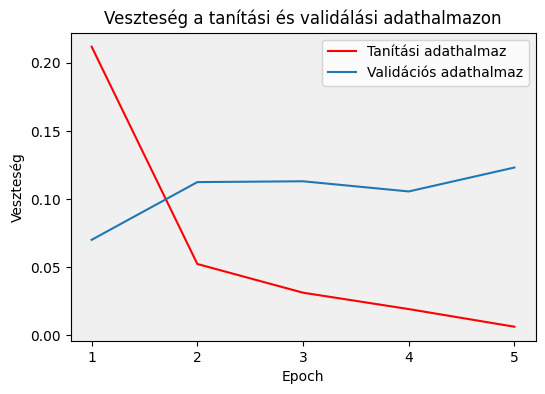

[{'model_name': 'bert-base-uncased', 'tokenizer_name': 'bert-base-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.3618444837857452, 0.10901771921431645, 0.059813148417872275, 0.03267154077578905, 0.017785118194458643], 'valid_loss': [0.14291205175220967, 0.13579777102917434, 0.10445050455629826, 0.09081972789717838, 0.12515681222314015], 'train_accuracy': [0.8175, 0.9615277777777778, 0.9788888888888889, 0.9901388888888889, 0.9941666666666666], 'valid_accuracy': [0.95375, 0.9475, 0.96625, 0.97375, 0.9625]}}, {'model_name': 'bert-large-uncased', 'tokenizer_name': 'bert-large-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.47493116392650536, 0.1675565809932434, 0.10065933298009137, 0.06883113098770587, 0.04243016161968828], 'valid_loss': [0.10775871896184981, 0.12478385265916586, 0.12206688501872122, 0.16946982083842158, 0.07890753752813907], 'train_accuracy': [0.7143055555555555, 0.9370833333333334, 0.9668055555555556, 0.9786111111111111, 0.986388888888888

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Testing model 'distilbert-base-uncased' with tokenizer 'distilbert-base-uncased'
Number of parameters:  66364418
Number of trainable parameters:  66364418


100%|██████████| 450/450 [02:38<00:00,  2.84it/s]


Epoch 1 		 Training Loss:      0.233 		 Validation Loss:      0.116
		 Training Accuracy:    90.236% 		 Validation Accuracy:    95.375%


100%|██████████| 450/450 [02:38<00:00,  2.84it/s]


Epoch 2 		 Training Loss:      0.096 		 Validation Loss:      0.134
		 Training Accuracy:    96.694% 		 Validation Accuracy:    94.375%


100%|██████████| 450/450 [02:38<00:00,  2.84it/s]


Epoch 3 		 Training Loss:      0.056 		 Validation Loss:      0.112
		 Training Accuracy:    98.250% 		 Validation Accuracy:    95.125%


100%|██████████| 450/450 [02:38<00:00,  2.84it/s]


Epoch 4 		 Training Loss:      0.029 		 Validation Loss:      0.119
		 Training Accuracy:    99.167% 		 Validation Accuracy:    97.000%


100%|██████████| 450/450 [02:38<00:00,  2.85it/s]


Epoch 5 		 Training Loss:      0.016 		 Validation Loss:      0.131
		 Training Accuracy:    99.486% 		 Validation Accuracy:    96.875%
Test Loss:      0.174
Test Accuracy: 0.957
Test Precision: 0.9616161616161616
Test Recall: 0.952
Test F1 Score: 0.9567839195979899
Test false_positives: 38
Test false_negatives: 48


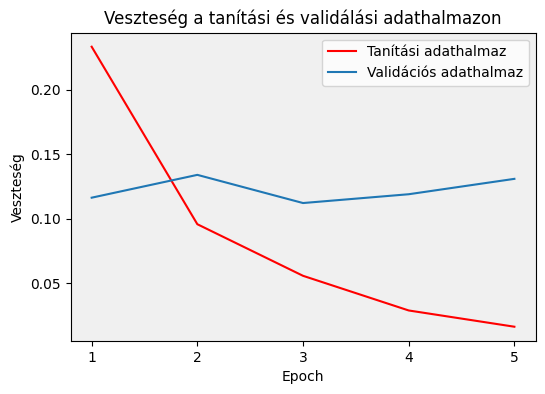

[{'model_name': 'bert-base-uncased', 'tokenizer_name': 'bert-base-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.3618444837857452, 0.10901771921431645, 0.059813148417872275, 0.03267154077578905, 0.017785118194458643], 'valid_loss': [0.14291205175220967, 0.13579777102917434, 0.10445050455629826, 0.09081972789717838, 0.12515681222314015], 'train_accuracy': [0.8175, 0.9615277777777778, 0.9788888888888889, 0.9901388888888889, 0.9941666666666666], 'valid_accuracy': [0.95375, 0.9475, 0.96625, 0.97375, 0.9625]}}, {'model_name': 'bert-large-uncased', 'tokenizer_name': 'bert-large-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.47493116392650536, 0.1675565809932434, 0.10065933298009137, 0.06883113098770587, 0.04243016161968828], 'valid_loss': [0.10775871896184981, 0.12478385265916586, 0.12206688501872122, 0.16946982083842158, 0.07890753752813907], 'train_accuracy': [0.7143055555555555, 0.9370833333333334, 0.9668055555555556, 0.9786111111111111, 0.986388888888888

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Testing model 'distilbert-base-cased' with tokenizer 'distilbert-base-cased'
Number of parameters:  65192450
Number of trainable parameters:  65192450


100%|██████████| 450/450 [02:38<00:00,  2.84it/s]


Epoch 1 		 Training Loss:      0.302 		 Validation Loss:      0.138
		 Training Accuracy:    84.944% 		 Validation Accuracy:    94.750%


100%|██████████| 450/450 [02:37<00:00,  2.85it/s]


Epoch 2 		 Training Loss:      0.112 		 Validation Loss:      0.120
		 Training Accuracy:    96.194% 		 Validation Accuracy:    95.750%


100%|██████████| 450/450 [02:38<00:00,  2.84it/s]


Epoch 3 		 Training Loss:      0.062 		 Validation Loss:      0.220
		 Training Accuracy:    97.889% 		 Validation Accuracy:    92.750%


100%|██████████| 450/450 [02:38<00:00,  2.84it/s]


Epoch 4 		 Training Loss:      0.028 		 Validation Loss:      0.140
		 Training Accuracy:    99.125% 		 Validation Accuracy:    95.750%


100%|██████████| 450/450 [02:37<00:00,  2.85it/s]


Epoch 5 		 Training Loss:      0.018 		 Validation Loss:      0.195
		 Training Accuracy:    99.292% 		 Validation Accuracy:    95.000%
Test Loss:      0.213
Test Accuracy: 0.937
Test Precision: 0.9561586638830898
Test Recall: 0.916
Test F1 Score: 0.9356486210418795
Test false_positives: 42
Test false_negatives: 84


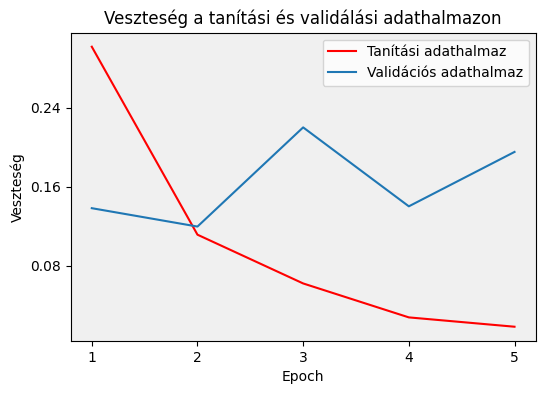

[{'model_name': 'bert-base-uncased', 'tokenizer_name': 'bert-base-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.3618444837857452, 0.10901771921431645, 0.059813148417872275, 0.03267154077578905, 0.017785118194458643], 'valid_loss': [0.14291205175220967, 0.13579777102917434, 0.10445050455629826, 0.09081972789717838, 0.12515681222314015], 'train_accuracy': [0.8175, 0.9615277777777778, 0.9788888888888889, 0.9901388888888889, 0.9941666666666666], 'valid_accuracy': [0.95375, 0.9475, 0.96625, 0.97375, 0.9625]}}, {'model_name': 'bert-large-uncased', 'tokenizer_name': 'bert-large-uncased', 'result': {'epoch': [1, 2, 3, 4, 5], 'train_loss': [0.47493116392650536, 0.1675565809932434, 0.10065933298009137, 0.06883113098770587, 0.04243016161968828], 'valid_loss': [0.10775871896184981, 0.12478385265916586, 0.12206688501872122, 0.16946982083842158, 0.07890753752813907], 'train_accuracy': [0.7143055555555555, 0.9370833333333334, 0.9668055555555556, 0.9786111111111111, 0.986388888888888

In [ ]:
config = [
    {
        'tokenizer_name': 'bert-base-uncased',
        'model_name': 'bert-base-uncased'
    },
    {
        'tokenizer_name': 'bert-large-uncased',
        'model_name': 'bert-large-uncased'
    },
    {
        'tokenizer_name': 'bert-base-cased',
        'model_name': 'bert-base-cased'
    },
    {
        'tokenizer_name': 'bert-large-cased',
        'model_name': 'bert-large-cased'
    },
    {
        'tokenizer_name': 'distilbert-base-uncased',
        'model_name': 'distilbert-base-uncased'
    },
    {
        'tokenizer_name': 'distilbert-base-cased',
        'model_name': 'distilbert-base-cased'
    }]

main(config)